# Usage of the Event Detector by Jin et al.

# Load the required packages

In [13]:



# Import public packages
import sys
import os
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import glob
from datetime import datetime, timedelta
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Jin
import BLUED_loader as blued

# Activate Autoreload
%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [14]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 

# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

<IPython.core.display.Javascript object>


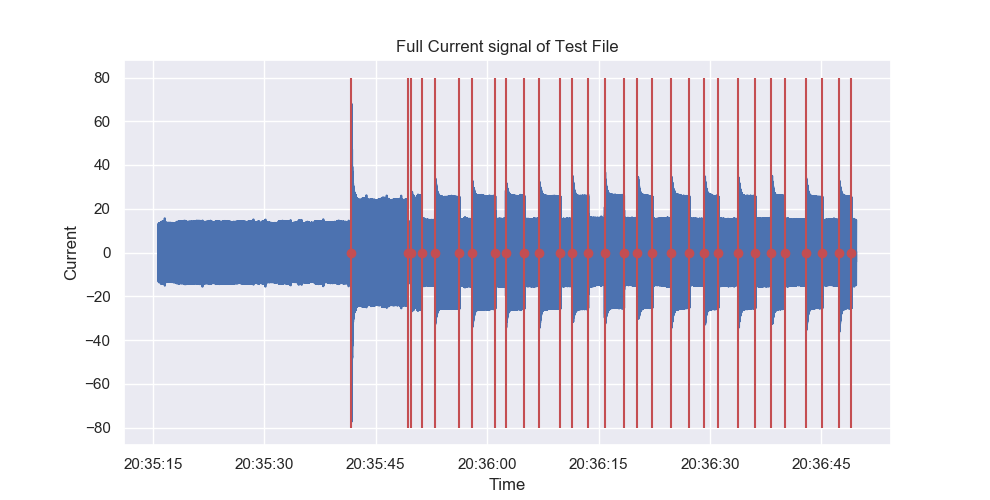

In [15]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data, file_info = blued.load_file(test_file)

lable_path:str = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.csv"))[0]
data_start = file_info['file_start']
data_end = file_info['file_end']

labels = blued.load_labels(lable_path, data_start, data_end)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
_, ax = plt.subplots(figsize=(9.9,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=labels.index, color='r',ymin=-80, ymax=80, zorder=101)
plt.show()


# Run the Event Detection on the Test Data

In [16]:
found_events=[]
show_plots = False

# Step 1: Initialize  the Event Detector
Jin = EventDet_Jin()

# Step 2: Fit the event detector on some portions of the data
voltage_training = voltage[:int(BLUED_period*60*30)] # just use 30 seconds for training here
current_training = current[:int(BLUED_period*60*30)]
active_power = Jin.compute_input_signal(voltage=voltage_training, current=current_training, period_length=BLUED_period)  
Jin = Jin.fit(x=active_power, sampling_rate=SAMPLERATE_BLUED) # Call the fit() method to further initialize the algorithm (required by the sklearn API)

# From the fit we get the required window size, the Jin algorithm estiamtes it based on the training data
window_size_samples = Jin.n_mean_  # the precomputed mean window size
window_size_seconds = window_size_samples / SAMPLERATE_BLUED #window_size in seconds
    
# Remove the training data from the overall data
voltage_testing = voltage[int(BLUED_period*60*30):]
current_testing = current[int(BLUED_period*60*30):]

samples_remaining = len(current_testing) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window
window_start_timestamp = current_testing.index[0] #first 30 seconds used for training
previous_window = None # Jin needs two windows, i.e. before and after event

while samples_remaining >= window_size_samples: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + window_size_samples) # compute end index of the new window
    window_end_timestamp = window_start_timestamp + timedelta(seconds=window_size_seconds)
    
    # Get the voltage and current windows
    voltage_window = voltage_testing[window_start:window_stop]
    current_window = current_testing[window_start:window_stop]
    
    print(">"+ f"  ({window_start}-{window_stop})")

    # Step 3: Use the feature computation function of the algorithm to compute the input features
    active_power = Jin.compute_input_signal(voltage=voltage_window, current=current_window, period_length=BLUED_period)     
    
    
    if previous_window is not None:
        X = np.stack([previous_window, active_power])
        
        # Step 4: Run the prediciton on the features
        events = Jin.predict(X, window_start_timestamp, window_end_timestamp) 

        if show_plots:
            plt.plot(X.flatten())
            plt.show()
                
        if events is not None: # if an event is returned
            for found_event in events:
                found_events.append(str(found_event))
                print(f"Event Detected at {found_event} - ({window_start_timestamp}-{window_end_timestamp})")
                
                #time_delta = window_end_timestamp-window_start_timestamp
                #time_delta_ms= int(time_delta.total_seconds()*10000)
                
                #pos_event = int((found_event - window_start_timestamp).total_seconds()*10000)
                #relative_pos = pos_event/time_delta_ms
                
                #event_idx = int((len(previous_window)+len(active_power))*relative_pos)
                #plt.vlines(x=[event_idx], color='red',ymin=-80, ymax=80, zorder=101)
                

    # We start at the end of the previous window
    window_start = int(window_stop)
    window_start_timestamp = window_end_timestamp
    
    # Set the previous window
    previous_window = active_power
    #print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining -= window_size_samples

>  (0-30126)
>  (30126-60252)
Event Detected at 2011-10-23 20:35:48.300666 - (2011-10-23 20:35:48.283999-2011-10-23 20:35:50.794499)
>  (60252-90378)
Event Detected at 2011-10-23 20:35:50.844499 - (2011-10-23 20:35:50.794499-2011-10-23 20:35:53.304999)
>  (90378-120504)
Event Detected at 2011-10-23 20:35:53.538332 - (2011-10-23 20:35:53.304999-2011-10-23 20:35:55.815499)
>  (120504-150630)
Event Detected at 2011-10-23 20:35:55.848832 - (2011-10-23 20:35:55.815499-2011-10-23 20:35:58.325999)
>  (150630-180756)
Event Detected at 2011-10-23 20:35:58.542666 - (2011-10-23 20:35:58.325999-2011-10-23 20:36:00.836499)
>  (180756-210882)
Event Detected at 2011-10-23 20:36:00.853166 - (2011-10-23 20:36:00.836499-2011-10-23 20:36:03.346999)
>  (210882-241008)
Event Detected at 2011-10-23 20:36:03.380332 - (2011-10-23 20:36:03.346999-2011-10-23 20:36:05.857499)
>  (241008-271134)
Event Detected at 2011-10-23 20:36:05.890832 - (2011-10-23 20:36:05.857499-2011-10-23 20:36:08.367999)
>  (271134-30126

<IPython.core.display.Javascript object>


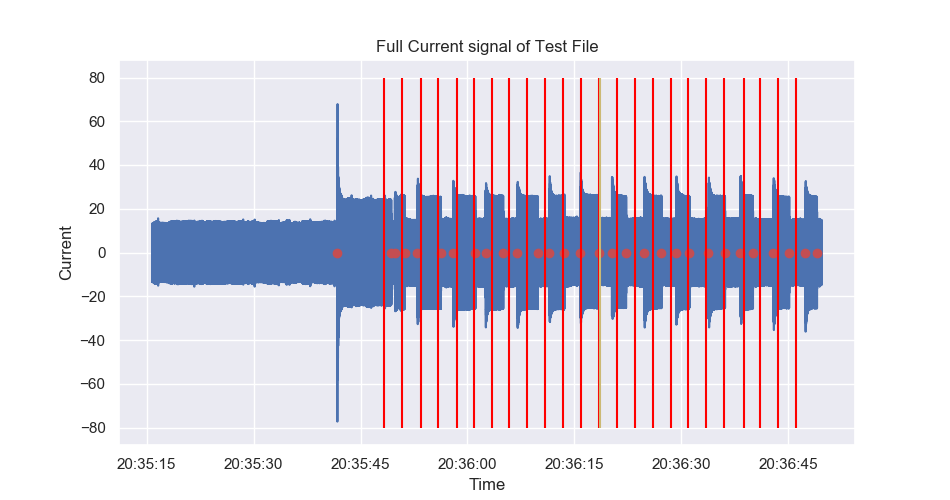

In [17]:
_, ax = plt.subplots(figsize=(9.5,5))
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")

ax.plot(current)
ax.scatter(x=labels.index, y=np.zeros(len(labels.index)), color='r',zorder=100)


ax.vlines(x=found_events, color='red',ymin=-80, ymax=80, zorder=101)

#end of sliding window
ax.vlines(x=data.index[window_start], color='y',ymin=-80, ymax=80, zorder=101)
plt.show()